# VarAnneal Tutorial

## Introduction
VarAnneal is a Python package for state and parameter estimation in partially observed dynamical systems and neural networks.  It uses variational annealing (VA), a variational data assimilation method.  VarAnneal is hosted on GitHub at [github.com/paulrozdeba/varanneal](http://github.com/paulrozdeba/varanneal).

In variational data assimilation, statistical path estimates conditioned on observational data are calculated using high-dimensional integrals of the form:
$$
\mathrm{E}\left[G(X) \lvert Y\right] = \frac{\int dX \: G(X)\: e^{-A(X,Y)}}{\int dX \: e^{-A(X,Y)}} \equiv \frac{1}{\mathcal{Z}(Y)} \int dX \: G(X)\: e^{-A(X,Y)}
$$
where $X$ is a vector of model states and parameters, and $Y$ is a vector of observational data.  These integrals may be approximated using Laplace's method around the dominant peaks of $P(X\lvert Y)$.  VA uses an annealing-like, numerical continuation method for finding these peaks using numerical optimization.  This optimization is carried out using one of a variety of methods, such as L-BFGS-B, NCG, IPOPT (future), ...   These methods require derivatives of $A$, which are computed with automatic differentiation (AD) using the PYADOLC wrapper around ADOL-C.

In dynamical systems, this amounts to estimating statistics for model parameters, as well as trajectories of model states, like the mode, mean, variance, ...  The data consists of time series of partial observations of the model variables.

In neural networks, this is used as a method of training the network weights on labeled data sets.

---

## ODE Example 1: Partially Observed Lorenz 96 with Uknown Parameter

In [1]:
# Necessary package imports
import time
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

In [2]:
from varanneal import va_ode  # The ODE version of VarAnneal

#### Data
Time series of $L$-dimensional observations $Y$:
$$
Y = \left\{ \mathbf{y}^1, \mathbf{y}^2, \ldots, \mathbf{y}^N \right\}
$$
where $\mathbf{y}^n = \mathbf{y}(t = t^n)$, $\mathbf{y}^n \in \mathbb{R}^L$ represents an observation at time $t^n$, and $t^1$ and $t^N$ are the times at the beginning and end of the observation window, respectively.  $\Delta t = t^{n} - t^{n-1}$ is the (constant) time interval between observations.

#### Model
$D$-dimensional Lorenz 96 ($D > L$):
$$
\frac{dx_i}{dt} = F_i(\mathbf{x}) \equiv x_{i-1} \left(x_{i+1} - x_{i-2}\right) - x_i + k
$$
where $\mathbf{x} \in \mathbb{R}^D$ is the state vector of the model system, and $k$ is a static parameter.

Our assumption is that the $\mathbf{y}^n$ is a noisy observation of $L$ out of $D$ Lorenz 96 system variables.  This means the observation function $\mathbf{h}$ has the following form:
$$
\mathbf{y}^n = \mathbf{h}(\mathbf{x}^n) = \mathbf{H}\mathbf{x}^n + \mathbf{\xi}^n
$$
where $\mathbf{H}: \mathbb{R}^D \to \mathbb{R}^L$ is a projection matrix with unit entries, i.e. $\sum_{j}H_{ij}x_j = x_i$, and $\mathbf{\xi}^n \sim N(0, R_m^{-1})$ is i.i.d. Gaussian noise with zero mean and a variance of $1/R_m$.

#### Discretization
The model system must be discretized in time:
$$
\mathbf{x}^{n_f+1} = \mathbf{f}(\mathbf{x}^{n_f}) = \mathbf{x}^{n_f} + \int\limits_{t^n}^{t^{n+1}} dt\: \mathbf{F}(\mathbf{x}(t))
$$
Define a grid of state variables $X$:
$$
X = \left\{ \mathbf{x}^1, \mathbf{x}^2, \ldots, \mathbf{x}^{N_f} \right\}
$$
where $\Delta t_f = t^{n_f} - t^{n_f - 1}$ is distinct from the data sampling time interval, and in general $\Delta t_f \leq \Delta t$.  However, $\Delta t / \Delta t_f$ should be rational so that there are state variables at all the observation times.

You also need to choose the numerical approximation method for discretization of $\mathbf{f}$.  For example, using Simpson-Hermite the model error is:
$$
\begin{align}
  \frac{1}{N} \sum_{n\text{ odd}}^{N-2} \sum_{i=1}^D R_{f,i} &\left\{x^{n+2}_i - x^n_i - \frac{\delta t}{6} \left[F_i(t^n, x^n) + 4 F_i(t^{n+1}, x^{n+1}) + F_i(t^{n+2}, x^{n+2})\right]\right\}^2 \nonumber \\
  &+ \left\{ x^{n+1}_i - \frac{1}{2}\left(x^n_i + x^{n+2}_i\right) - \frac{\delta t}{8}\left[F_i(t^n, x^n) - F_i(t^{n+2}, x^{n+2})\right]\right\}^2
\end{align}
$$
VarAnneal lets you choose between Simpson-Hermite, RK2, RK4, and the trapezoid rule.  These are the built-in methods, but in princple any discretization scheme is definable in the code.

#### Define the ODE system

In [3]:
def l96(t, x, k):
    # Define this as you would any ODE system in Python, when x is a *time series* 
    # of states.
    # Note that using loops will not cause any noticeable slowdown with PYADOLC 
    # (as opposed to vectorized Numpy operations on vectors), and in fact you 
    # should be careful which Numpy vector functions you use (all of the "allowed" 
    # Numpy functions are defined in the PYADOLC source code).
    
    # Define a vector to store the elements of the ODE vector field.
    # Note that using numpy.zeros_like avoids the need to overload this function for 
    # object vs. numerical types (important when function is being taped vs. evaluated).
    dxdt = np.zeros_like(x)  # will have shape (N, D)
    D = x.shape[1]
    for i in range(D):
        dxdt[:, i] = x[:, (i-1)%D] * (x[:, (i+1)%D] - x[:, (i-2)%D]) - x[:, i] + k
    return dxdt
    
    # fancy footwork version below
    #return np.roll(x,1,1) * (np.roll(x,-1,1) - np.roll(x,2,1)) - x + k

#### Action/annealing (hyper)parameters

In [4]:
# Model system dimension
D = 20

# Measured variable indices
Lidx = [0, 2, 4, 6, 8, 10, 14, 16]

# RM, RF0
RM = 1.0 / (0.5**2)
RF0 = 4.0e-6

# alpha, and beta ladder
alpha = 1.5
beta_array = np.linspace(0, 100, 101)

g0 = RF0/RM
gammas_all = g0 * alpha**beta_array

#### Load observed data

In [5]:
# The data file included with this example contains observations of all D=20 
# components.  We need to load it and extract just the measured components.
data = np.load("Lorenz96/data/l96_D20_k8p17_data_dt0p05_N161_sm0p5.npy")

# Extract observation times
times_data = data[:, 0]
dt_data = times_data[1] - times_data[0]
N_data = len(times_data)

# Get out just the data
data = data[:, 1:]
data = data[:, Lidx]

Set $\Delta t_f$ based on $\Delta t$.

In [6]:
# model state discretization
freq_mod = 1.0  # how often to put down a state variable
dt_model = dt_data / freq_mod
if freq_mod == 1.0:
    N_model = N_data
else:
    N_model = int(N_data * freq_mod) - 1

#### Initial path/parameter guesses
Later in the notebook, we'll have the option of setting the initial guesses for the observed variables equal to the observations themselves.

In [7]:
# State variables
# This should be an array with N_f elements, where element n_f is a D-dimensional 
# vector. In other words, this is an array of state vectors at all "model times".
X0 = (20.0*np.random.rand(N_model * D) - 10.0).reshape((N_model, D))

# Parameters
Pidx = [0]  # indices of estimated parameters
# Initial guess
P0 = np.array([4.0 * np.random.rand() + 6.0])  # Static parameter
#Pinit = 4.0 * np.random.rand(N_model, 1) + 6.0  # Time-dependent parameter

#### Use VA to estimate states and parameters
First we need to initialize an Annealer object, which stores information about the model, data, annealing hyperparameters, and the action.  It also executes the VA algorithm, then is used to save the state and parameter estimates to file.

In [8]:
# Initialize Annealer
anneal_l96 = va_ode.Annealer()

# Set the Lorenz 96 model
anneal_l96.set_model(l96, D)

# Load the data into the Annealer object
anneal_l96.set_data(data, t=times_data)

Run VA

In [ ]:
# First set some options for the optimization.
# The full list of options can be found in the scipy.optimization package documentation.
BFGS_options = {'gtol':1.0e-8, 'ftol':1.0e-8, 'maxfun':1000000, 'maxiter':1000000}

tstart = time.time()  # time how long VA takes

# Annealer.anneal() executes VA for all beta values (defined above)
# Note the init_to_data option: this initializes the measured variables to the data.
anneal_l96.anneal(X0, P0, alpha, beta_array, RM, RF0, Lidx, Pidx, dt_model=dt_model,
                  init_to_data=True, disc='SimpsonHermite', method='L-BFGS-B',
                  opt_args=BFGS_options, adolcID=0)

print("\nADOL-C annealing completed in %f s."%(time.time() - tstart))

#### Save action, constituent errors, and state/parameter estimates to file.

In [11]:
anneal_l96.save_paths("Lorenz96/results/paths_D20_L8_N161.npy")
anneal_l96.save_params("Lorenz96/results/params_D20_L8_N161.npy")
anneal_l96.save_action_errors("Lorenz96/results/aerr_D20_L8_N161.npy")

### Plot the results

#### One measured, one unmeasured state variable

In [110]:
# Load path & parameter estimates, and action curves
allpaths = np.load("Lorenz96/results/paths_D20_L8_N161.npy")
allparam = np.load("Lorenz96/results/params_D20_L8_N161.npy")
aerr = np.load("Lorenz96/results/aerr_D20_L8_N161.npy")

# Load the true solution
true_soln = np.load("Lorenz96/data/l96_D20_k8p17_truesoln_dt0p05_N161.npy")

<IPython.core.display.Javascript object>


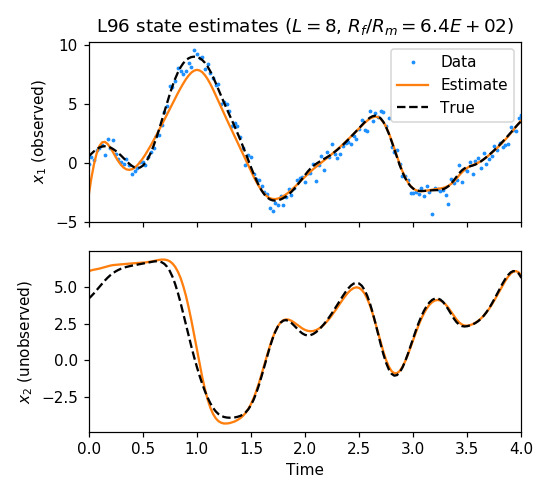

In [107]:
beta_show = 50  # plot estimates at this beta value

plot_idx_meas = 1  # measured component index (time has index 0)
plot_idx_meas_dataidx = 0  # measured component index in data array
plot_idx_unmeas = 2  # unmeasured component index (time has index 0)

# plot all path estimates at this beta simultaneously
fig,ax = plt.subplots(2, 1, figsize=(5, 4.5), sharex=True)
fig.set_tight_layout(True)

tplot = allpaths[beta_show, :, 0]

# Observed variable
# plot the data
ax[0].plot(tplot, data[:, plot_idx_meas_dataidx], color="dodgerblue", label="Data", marker=".", ms=3, lw=0)#, alpha=0.7)#, lw=1.5)
# plot the estimate
ax[0].plot(tplot, allpaths[beta_show, :, plot_idx_meas], color="C1", label="Estimate")#, alpha=1.0, lw=2.0)
# plot the true solution
ax[0].plot(tplot, true_soln[:, plot_idx_meas], color="black", label="True", ls="--")#, lw=1.5, alpha=0.7)
ax[0].set_xlim(tplot[0], tplot[-1])
ax[0].set_ylabel(r"$x_%d$ (observed)"%(plot_idx_meas))
ax[0].set_title(r"L96 state estimates ($L=8$, $R_f/R_m = %.1E$)"%(RF0/RM * alpha**beta_show))

h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,l)

# Unobserved variable
# plot the estimate
ax[1].plot(tplot, allpaths[beta_show, :, plot_idx_unmeas], color="C1")#, alpha=1.0, lw=2.0)
# plot the true solution
ax[1].plot(tplot, true_soln[:, plot_idx_unmeas], color="black", ls="--")#, alpha=0.7)#, lw=1.5)
ax[1].set_xlim(tplot[0], tplot[-1])
ax[1].set_ylabel(r"$x_%d$ (unobserved)"%(plot_idx_unmeas))
ax[1].set_xlabel("Time")

plt.show()
#fig.savefig("/home/prozdeba/CloudStation/write-ups/dynamical_reg_L96_20170123/figs/L96_estimates_L7.pdf")

#### Plot parameter estimate over course of annealing

<IPython.core.display.Javascript object>


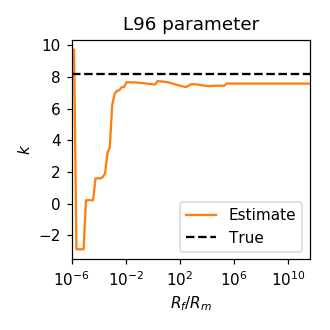

In [123]:
fig,ax = plt.subplots(1, 1, figsize=(3,3))
fig.set_tight_layout(True)

ax.plot(gammas_all, allparam, color="C1", label="Estimate")#, lw=0, marker='.', ms=3)
ax.axhline(y=8.17, color="black", label="True", ls="--")
ax.set_xscale('log')
ax.set_xlim(gammas_all[0], gammas_all[-1])
ax.set_xlabel(r"$R_f/R_m$")
ax.set_ylabel("$k$")
ax.set_title("L96 parameter")

h,l = ax.get_legend_handles_labels()
ax.legend(h,l)

plt.show()

#### Plot the action

<IPython.core.display.Javascript object>


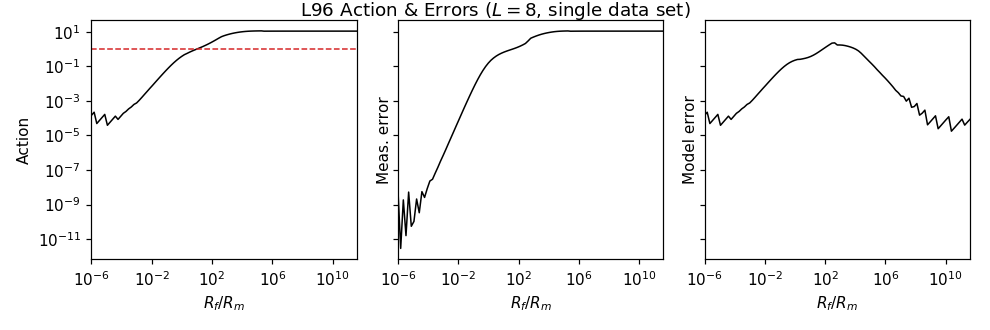

In [109]:
fig,ax = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
fig.set_tight_layout(True)

ymin = 1.0e20
ymax = 0.0

plotlw = 1.0
plotalpha = 1
#plotcolors = ["C0", "C0", "C0"]
plotcolors = ["black", "black", "black"]

action_vals = aerr[:, 1]
ax[0].plot(gammas_all[:], action_vals, lw=plotlw, color=plotcolors[0], alpha=plotalpha)
ax[0].set_xlabel(r"$R_f/R_m$")
ax[0].set_ylabel("Action")
ax[0].axhline(y=1, lw=1, ls="--", color="C3")#, alpha=.7)

measerr_vals = aerr[:, 2]
ax[1].plot(gammas_all[:], measerr_vals, lw=plotlw, color=plotcolors[1], alpha=plotalpha)
ax[1].set_xlabel(r"$R_f/R_m$")
ax[1].set_ylabel("Meas. error")

moderr_vals = aerr[:, 3]
ax[2].plot(gammas_all[:], moderr_vals, lw=plotlw, color=plotcolors[2], alpha=plotalpha)
ax[2].set_xlabel(r"$R_f/R_m$")
ax[2].set_ylabel("Model error")

fig.suptitle("L96 Action & Errors ($L=8$, single data set)", y=1.0)

for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlim(gammas_all[0], gammas_all[-1])
    #ax[i].set_ylim(.001, 1.0e2)

plt.show()

---

## ODE Example 2: Voltage Observations of a Neuron, Modeled with "Simple" HH

In [1]:
# Necessary package imports
import time
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

In [2]:
from varanneal import va_ode  # The ODE version of VarAnneal

In this example, observations of the voltage trace of a neuron stimulated with a known input current (known as a current clamp protocol) are simulated in a twin experiment.  A "simple" Hodgkin-Huxley model (called NaKL) is integrated forward in time with a known time-dependent stimulus, and the solution is sampled at regular intervals with some random noise to simulate noise in a real electrode.

The NaKL model is:
$$
\begin{align}
\frac{dV}{dt} &= g_{Na} m^3 h \left(E_{Na} - V\right) + g_K n^4 \left(E_K - V\right) + g_L \left(E_L - V\right) + I(t) \\
\frac{dz}{dt} &= \frac{z_\infty(V) - z}{\tau_z(V)} \quad \left(z = m, h, n\right) \\
z_\infty(V) &= \frac{1}{2} \left[1 + \tanh\left(\frac{V - V_z}{\sigma_z}\right) \right], \quad \tau_z(V) = \tau_{1,z} + \tau_{2,z} \left[1 - \tanh\left(\frac{V - V_z}{\sigma_z}\right) \right]
\end{align}
$$
The various model parameters are assumed to be unknown, or only known to within some finite range.  Additionally, only the voltage is actually measured.  We will thus use VarAnneal to estimate the gating variable states, and all of the model parameters, from voltage data and the known stimulus current $I(t)$.

### New considerations (compared to Lorenz 96)
- Now there is an input current.  We need to make sure we feed VarAnneal this input current correctly, in addition to defining the ODE system properly to take in multiple parameters and the input current (see function definition below).
- Voltage has units, while gating variables do not; and voltage operates on a different "dynamical scale".  That is, over similar amounts of time, voltage will vary between (roughly) -100 and 100 mV, while the gating variables are bound to the range (0, 1).  This is problematic if $R_f$ is a scalar, because the voltage model error terms will be weighted more strongly than the gating variables for nothing more than dimensional reasons.  Two possible solutions are (1) set a different $R_f$ for each model component, or (2) rescale the voltage data so that it also lies within the interval (0, 1).  Here we're going to choose option (1), setting $R_f$ for voltage to be $10^4$ times smaller than for the gating variables.

#### Define the ODE system

In [3]:
# rate functions
def x_inf(V, Vt, Vs):
    return 0.5*(1.0 + np.tanh((V - Vt)/Vs))

def x_tau(V, Vt, Vs, t1, t2):
    return t1 + t2*(1.0 - np.tanh((V - Vt)/Vs)**2)

# ODE system
def nakl(t, x, pstim):
    # Define this as you would any ODE system in Python, when x is a *time series* 
    # of states.
    
    # Now define a vector to store the elements of the ODE vector field.
    # Note that using numpy.zeros_like avoids the need to overload this function for 
    # object vs. numerical types (important when function is being taped vs. evaluated).
    dxdt = np.zeros_like(x)  # will have shape (N, D)
    # If there is a stimulus, pstim (third argument) is assumed to be a tuple like
    #    (parameters, stimlulus time series)
    p,Iext = pstim
    
    # name the states and parameters
    V, m, h, n = (x[:, 0], x[:, 1], x[:, 2], x[:, 3])
    gNa, gK, gL = (p[0], p[1], p[2])
    ENa, EK, EL = (p[3], p[4], p[5])
    Vtm, Vsm, t1m, t2m = (p[6], p[7], p[8], p[9])
    Vth, Vsh, t1h, t2h = (p[10], p[11], p[12], p[13])
    Vtn, Vsn, t1n, t2n = (p[14], p[15], p[16], p[17])

    dxdt[:, 0] = gNa * m**3 * h * (ENa - V) + gK * n**4 * (EK - V) + gL * (EL - V) + Iext
    dxdt[:, 1] = (x_inf(V, Vtm, Vsm) - m) / x_tau(V, Vtm, Vsm, t1m, t2m)
    dxdt[:, 2] = (x_inf(V, Vth, Vsh) - h) / x_tau(V, Vth, Vsh, t1h, t2h)
    dxdt[:, 3] = (x_inf(V, Vtn, Vsn) - n) / x_tau(V, Vtn, Vsn, t1n, t2n)
    
    return dxdt

#### Action/annealing (hyper)parameters

In [4]:
# Model system dimension
D = 4

# Measured variable indices
Lidx = [0]

# RM and RF0
RM = 1.0
# Note that we're considering a *different* RF for each model component.
# Definining it this way treats RF like a diagonal matrix.
RF0 = [1.0E-8, 1.0E-4, 1.0E-4, 1.0E-4]

# alpha, and beta ladder
alpha = 1.1
beta_all = np.linspace(0, 400, 401)

gamma0 = RF0[0]/RM
gamma_all = gamma0 * alpha**beta_all

#### Load observation & stimulus data
Note that VarAnneal also contains convenience functions for loading in data from files without needing to manually manipulate arrays like this.  I'll show an example a few cells down, after the Annealer object is initialized.

In [5]:
# The data file included with this example contains observations of all D=20 
# components.  We need to load it and extract just the measured components.
data = np.load("NaKL/data/NaKL_Vdata_dt0p02_N6001_sm1p0.npy")

# Extract observation times
times_data = data[:, 0]
dt_data = times_data[1] - times_data[0]
N_data = len(times_data)

# Get out just the data
data = data[:, 1:]
data = data[:, Lidx]

###################################
# Stimulus
stim = np.load("NaKL/data/NaKL_stim_dt0p02_N6001.npy")
stim = stim[:, 1]

#### Set $\Delta t_f$ based on $\Delta t$.

In [6]:
# model state discretization
freq_mod = 1.0  # how often to put down a state variable
dt_model = dt_data / freq_mod
if freq_mod == 1.0:
    N_model = N_data
else:
    N_model = int(N_data * freq_mod) - 1

#### Initial path/parameter guesses

In [7]:
# State variables
# This should be an array with N_f elements, where element n_f is a D-dimensional 
# vector. In other words, this is an array of state vectors at all "model times".
Xinit = 0.2*np.random.rand(N_model, D) + 0.4
# Note we didn't rescale V init, to reflect its wider dynamical range of -100 to +100.
# Later we're going to set it equal to the data anyway!

##############################
# Parameters
Pidx = range(18)  # indices of estimated parameters
#Pidx = []  # leave empty to estimate no parameters

# Initial guess
# Start by defining bounds for initial guesses (later used for optimization bounds)
Pb = []
Pb.append([60.0, 180.0])  # gNa_b
Pb.append([10.0, 30.0])  # gK_b
Pb.append([0.15, 0.45])  # gL_b
Pb.append([47.5, 52.5])  # ENa_b
Pb.append([-80.85, -73.15])  # EK_b
Pb.append([-56.7, -51.3])  # EL_b
Pb.append([-42.0, -38.0])  # Vtm_b
Pb.append([14.25, 15.75])  # Vsm_b
Pb.append([0.095, 0.105])  # t1m_b
Pb.append([0.38, 0.42])  # t2m_b
Pb.append([-63.0, -57.0])  # Vth_b
Pb.append([-15.75, -14.25])  # Vsh_b
Pb.append([0.95, 1.05])  # t1h_b
Pb.append([6.65, 7.35])  # t2h_b
Pb.append([-57.75, -52.25])  # Vtn_b
Pb.append([28.5, 31.5])  # Vsn_b
Pb.append([0.95, 1.05])  # t1n_b
Pb.append([4.75, 5.25])  # t2n_b

# Draw initial guesses from these intervals
Pinit = np.zeros(len(Pidx))
for i,b in enumerate(Pb):
    r = b[1] - b[0]
    Pinit[i]= r*np.random.rand() + b[0]
Pinit = np.array(Pinit)
#Pinit = np.load("NaKL/NaKL_trueparam_dt0p02_N6001.npy")  # use this to load in true parameters

#### Initialize VarAnneal object to estimate states and parameters

In [8]:
# Initialize Annealer
anneal_nakl = va_ode.Annealer()

# Set the NaKL model
anneal_nakl.set_model(nakl, D)

# Load the data and stimulus into the Annealer object
anneal_nakl.set_data(data, stim=stim, t=times_data)

#### Run VA
Note that the tolerance on f and g for termination of BFGS has been turned up here, compared to the Lorenz 96 example.  This example still runs fine with 10^-8 but will take much longer, and using 10^-4 was found to produce good accuracy anyway.

In [9]:
# First set some options for the optimization and annealing loop
# Bounds
bounds = [[-100.0, 100.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]
for i in xrange(len(Pidx)):
    bounds.append(Pb[i])
    #bounds.append([None, None])

# The full list of BFGS options can be found in the scipy.optimization package documentation.
BFGS_options = {'gtol':1.0e-8, 'ftol':1.0e-8, 'maxfun':1000000, 'maxiter':1000000}

# Set up dictionaries with necessary info for tracking progress
# Don't pass these as arguments to anneal() if you don't want to track progress
track_paths = {'filename':"NaKL/results/inprog_paths.npy"}
track_params = {'filename':"NaKL/results/inprog_params.npy"}
track_action_errors = {'filename':"NaKL/results/inprog_aerr.npy"}

In [ ]:
tstart = time.time()  # time how long VA takes

# Annealer.anneal() executes VA for all beta values (defined above)
# Note the init_to_data option: this initializes the measured variables to the data.
anneal_nakl.anneal(Xinit, Pinit, alpha, beta_all, RM, RF0, Lidx, Pidx, dt_model=dt_model,
                   init_to_data=True, disc='SimpsonHermite', method='L-BFGS-B',
                   opt_args=BFGS_options, adolcID=0, bounds=bounds, track_paths=track_paths, 
                   track_params=track_params, track_action_errors=track_action_errors)

print("\nADOL-C annealing completed in %f s."%(time.time() - tstart))

#### Save action, constituent errors, and state/parameter estimates to file.

In [31]:
anneal_nakl.save_paths("NaKL/results/paths.npy")
anneal_nakl.save_params("NaKL/results/params.npy")
anneal_nakl.save_action_errors("NaKL/results/aerr.npy")

### Plot the results

In [10]:
# Load path & parameter estimates, and action curves
allpaths = np.load("NaKL/results/paths.npy")
allparam = np.load("NaKL/results/params.npy")
aerr = np.load("NaKL/results/aerr.npy")

# Load the true solution and parameters
true_soln = np.load("NaKL/data/NaKL_truesoln_dt0p02_N6001.npy")
true_soln_allg = np.resize(true_soln, allpaths.shape)
true_param = np.load("NaKL/data/NaKL_trueparam_dt0p02_N6001.npy")

#### Plot all state variable estimates

In [ ]:
beta_show = 180  # plot estimates at this beta value

# plot all path estimates at this beta simultaneously
fig,ax = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
fig.set_tight_layout(True)

tplot = allpaths[beta_show, :, 0]

# Observed variable (voltage)
# plot the data
ax[0].plot(tplot, data[:, 0], color="dodgerblue", label="Data", marker=".", ms=3, lw=0)#, alpha=0.7)#, lw=1.5)
# plot the estimate
ax[0].plot(tplot, allpaths[beta_show, :, 1], color="C1", label="Estimate")#, alpha=1.0, lw=2.0)
# plot the true solution
ax[0].plot(tplot, true_soln[:, 1], color="black", label="True", ls="--")#, lw=1.5, alpha=0.7)
ax[0].set_xlim(tplot[0], tplot[-1])
ax[0].set_ylabel(r"$V$ (observed)")
ax[0].set_title(r"NaKL state estimates ($R_f/R_m = %.1E$)"%(RF0[0]/RM * alpha**beta_show))

h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,l)

# Unobserved variables (gating variables)
gvnames = ["m", "h", "n"]
for i in [1, 2, 3]:
    # plot the estimate
    ax[i].plot(tplot, allpaths[beta_show, :, i], color="C1")#, alpha=1.0, lw=2.0)
    # plot the true solution
    ax[i].plot(tplot, true_soln[:, i], color="black", ls="--")#, alpha=0.7)#, lw=1.5)
    ax[i].set_xlim(tplot[0], tplot[-1])
    ax[i].set_ylabel(r"$%s$ (unobserved)"%(gvnames[i-1]))
    #ax[1].set_xlabel("Time")

ax[3].set_xlabel("Time")

plt.show()
#fig.savefig("/home/prozdeba/CloudStation/write-ups/dynamical_reg_L96_20170123/figs/L96_estimates_L7.pdf")

#### Plot the action

In [ ]:
fig,ax = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
fig.set_tight_layout(True)

ymin = 1.0e20
ymax = 0.0

plotlw = 1.0
plotalpha = 1
#plotcolors = ["C0", "C0", "C0"]
plotcolors = ["black", "black", "black"]

action_vals = aerr[:, 1]
ax[0].plot(gammas_all[:], action_vals, lw=plotlw, color=plotcolors[0], alpha=plotalpha)
ax[0].set_xlabel(r"$R_f/R_m$")
ax[0].set_ylabel("Action")
ax[0].axhline(y=1, lw=1, ls="--", color="C3")#, alpha=.7)

measerr_vals = aerr[:, 2]
ax[1].plot(gammas_all[:], measerr_vals, lw=plotlw, color=plotcolors[1], alpha=plotalpha)
ax[1].set_xlabel(r"$R_f/R_m$")
ax[1].set_ylabel("Meas. error")

moderr_vals = aerr[:, 3]
ax[2].plot(gammas_all[:], moderr_vals, lw=plotlw, color=plotcolors[2], alpha=plotalpha)
ax[2].set_xlabel(r"$R_f/R_m$")
ax[2].set_ylabel("Model error")

fig.suptitle("NaKL Action & Errors (single data set)", y=1.0)

for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlim(gammas_all[0], gammas_all[-1])
    #ax[i].set_ylim(.001, 1.0e2)

plt.show()

---

## Neural Network Example 1: All-to-All Feed-Forward Network for MNIST Image Recognition

In [ ]:
# Necessary package imports
import time
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

In [3]:
from varanneal import va_nnet

#### Data
$M$ pairs of data, each consisting of a handwritten image (the input) and a label for the image, which is which digit a human decides the image is of (the output), forming the data $Y$.

#### Model
Here we use an all-to-all feed-forward neural network with 3 layers: one input, one output, and one hidden layer.  The input and output layer sizes are fixed by the number of pixels in each image and the number of possible labels, respectively.

The state of the network, $X$, is a collection of neuron activations in each layer:
$$
X = \left\{ \mathbf{x}^{l_1}, \mathbf{x}^{l_2}, \ldots, \mathbf{x}^{l_F} \right\}
$$

The state of the network in layer $l_n$ is transferred to layer $l_{n+1}$ according to the activation function:
$$
\mathbf{x}^{n+1} = \sigma(\mathbf{x}^{n}, \mathbf{W}^{n+1}) = \frac{1}{1 + \exp \left[-\mathbf{W}^{n+1} \cdot \mathbf{x}^n \right]}
$$
where $\mathbf{W}^n$ is the matrix of "synaptic" weights between layer $n-1$ and $n$.

#### Define the activation function

In [34]:
def sigmoid(x, W, b):
    linpart = np.dot(W, x) + b
    return 1.0 / (1.0 + np.exp(-linpart))

#### Network structure

In [35]:
N = 3  # Total umber of layers
D_in = 784  # Number of neurons in the input layer
D_out = 10  # Number of neurons in the output layer
D_hidden = 30  # Number of neurons in the hidden layers

# Network structure is stored in a list, where element i is the number 
# of neurons in layer i.
structure = np.zeros(N, dtype='int')
structure[0] = D_in  # 3 neurons in the input layer
structure[N-1] = D_out  # 2 neurons in the output layer
for i in range(1, N-1):
    structure[i] = D_hidden  # 5 neurons in the hidden layers

Lidx = [np.linspace(0, D_in-1, D_in, dtype='int'), np.linspace(0, D_out-1, D_out, dtype='int')]

#### Action/annealing parameters

In [36]:
# RM, RF0
RM = 1.0
RF0 = 1.0e-8 * RM * float(np.sum(structure) - structure[0]) / float(structure[0] + structure[-1])
g0 = RF0 / RM

# alpha, and beta ladder
alpha = 1.1
beta_array = np.linspace(0, 435, 436)
gammas_all = g0 * alpha**beta_array

#### Load MNIST data set (images and labels)

In [10]:
M = 2  # number of training examples
data_in = np.load("MNIST/MNIST_data/imtrain_norm.npy")[:M]
data_out = np.load("MNIST/MNIST_data/labtrain.npy")[:M]

#### Initial neuron activation/weight guesses

In [11]:
np.random.seed(27509436)

# Neuron states
Xin = np.random.randn(D_in)
Xin = (Xin - np.average(Xin)) / np.std(Xin)
X0 = np.copy(Xin)

for n in xrange(N-2):
    X0 = np.append(X0, 0.2*np.random.rand(D_hidden) + 0.4)
X0 = np.append(X0, 0.2*np.random.rand(D_out) + 0.4)

for m in xrange(M - 1):
    Xin = np.random.randn(D_in)
    Xin = (Xin - np.average(Xin)) / np.std(Xin)
    X0 = np.append(X0, Xin)
    for n in xrange(N-2):
        X0 = np.append(X0, 0.2*np.random.rand(D_hidden) + 0.4)
    X0 = np.append(X0, 0.2*np.random.rand(D_out) + 0.4)

X0 = np.array(X0).flatten()

# Parameters
NP = np.sum(structure[1:]*structure[:-1] + structure[1:])
P0 = np.array([], dtype=np.float64)

W_i0 = 0
W_if = structure[0]*structure[1]
b_i0 = W_if
b_if = b_i0 + structure[1]

# Set up Pidx so that only weights, not biases, are estimated
for n in xrange(N - 1):
    if n == 0:
        Pidx = np.arange(W_i0, W_if, 1, dtype='int')
    else:
        Pidx = np.append(Pidx, np.arange(W_i0, W_if, 1, dtype='int'))
    if n == 0:
        P0 = np.append(P0, (2.0*np.random.rand(structure[n]*structure[n+1]) - 1.0) / D_in)
    else:
        P0 = np.append(P0, (2.0*np.random.rand(structure[n]*structure[n+1]) - 1.0) / D_hidden)
    P0 = np.append(P0, np.zeros(structure[n+1]))

    if n < N - 2:
        W_i0 = b_if
        W_if = W_i0 + structure[n+1]*structure[n+2]
        b_i0 = W_if
        b_if = b_i0 + structure[n+2]

P0 = np.array(P0).flatten()
Pidx = np.array(Pidx).flatten().tolist()

### Use VA to train the network weights

In [13]:
# Initialize Annealer
anneal1 = va_nnet.Annealer()
# Set the network structure
anneal1.set_structure(structure)
# Set the activation function
anneal1.set_activation(sigmoid)
# Set the input and output data
anneal1.set_input_data(data_in)
anneal1.set_output_data(data_out)

#### Run VA using L-BFGS-B

In [15]:
BFGS_options = {'gtol':1.0e-12, 'ftol':1.0e-12, 'maxfun':1000000, 'maxiter':1000000}

tstart = time.time()
anneal1.anneal(X0, P0, alpha, beta_array, RM, RF0, Pidx, Lidx=Lidx,
               method='L-BFGS-B', opt_args=BFGS_options, adolcID=0)

print("\nADOL-C annealing completed in %f s."%(time.time() - tstart))

------------------------------
Step 1 of 436
beta = 0, RF = 5.03778338e-10

Taping action evaluation...
Done!
Time = 0.207283973694 s

Beginning optimization...
Optimization complete!
Time = 0.0408389568329 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  3.28725617e-11]

------------------------------
Step 2 of 436
beta = 1, RF = 5.54156171e-10

Taping action evaluation...
Done!
Time = 0.16681098938 s

Beginning optimization...
Optimization complete!
Time = 0.0275549888611 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  3.61598127e-11]

------------------------------
Step 3 of 436
beta = 2, RF = 6.09571788e-10

Taping action evaluation...
Done!
Time = 0.17361497879 s

Beginning optimization...
Optimization complete!
Time = 0.0329079627991 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function valu

#### Save the output

In [18]:
anneal1.save_io("MNIST/results/io.npy")
anneal1.save_Wb("MNIST/results/W.npy", "MNIST/results/b.npy")
anneal1.save_action_errors("MNIST/results/action_errors.npy")

### Plot the results

In [37]:
# Load action curves
aerr = np.load("MNIST/results/action_errors.npy")

<IPython.core.display.Javascript object>


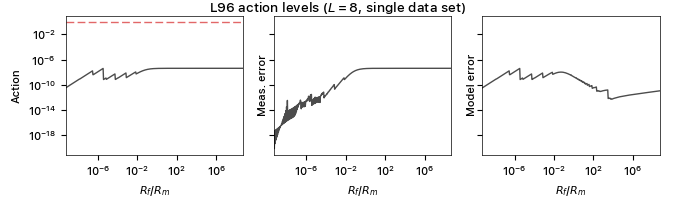

In [41]:
fig,ax = plt.subplots(1, 3, figsize=(6.75, 2.1), sharey=True)
fig.set_tight_layout(True)

ymin = 1.0e20
ymax = 0.0

plotlw = 1.0
plotalpha = .7
#plotcolors = ["C0", "C0", "C0"]
plotcolors = ["black", "black", "black"]

action_vals = aerr[:, 1]
ax[0].plot(gammas_all[:], action_vals, lw=plotlw, color=plotcolors[0], alpha=plotalpha)
ax[0].set_xlabel(r"$R_f/R_m$")
ax[0].set_ylabel("Action")
ax[0].axhline(y=1, lw=1, ls="--", color="C3", alpha=.7)

measerr_vals = aerr[:, 2]
ax[1].plot(gammas_all[:], measerr_vals, lw=plotlw, color=plotcolors[1], alpha=plotalpha)
ax[1].set_xlabel(r"$R_f/R_m$")
ax[1].set_ylabel("Meas. error")

moderr_vals = aerr[:, 3]
ax[2].plot(gammas_all[:], moderr_vals, lw=plotlw, color=plotcolors[2], alpha=plotalpha)
ax[2].set_xlabel(r"$R_f/R_m$")
ax[2].set_ylabel("Model error")

fig.suptitle("L96 action levels ($L=8$, single data set)", y=1.0)

for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlim(gammas_all[0], gammas_all[-1])
    #ax[i].set_ylim(.001, 1.0e2)

plt.show()

#### Parameter estimates

In [43]:
#structure = np.array([25, 3, 4])
Nbias = np.sum(structure[1:])
Nweight = np.sum(structure[1:] * structure[:-1])

sortedp = []

West = np.load("MNIST/results/W.npy")
best = np.load("MNIST/results/b.npy")

for i in xrange(len(gammas_all)):
    #West = np.load("W.npy")
    #best = np.load("b.npy")
    for j, West_n in enumerate(West[i]):
        if j == 0:
            pest = West_n.flatten()#, best_n.flatten())
        else:
            pest = np.append(pest, West_n.flatten())
    for j, best_n in enumerate(best[i]):
        pest = np.append(pest, best_n.flatten())
    sortedp.append(pest.flatten())

sortedp = np.array(sortedp)

<IPython.core.display.Javascript object>


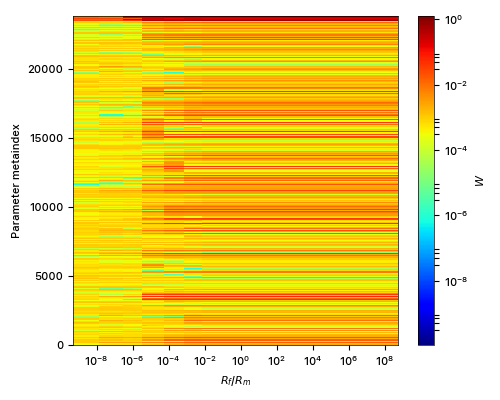

In [44]:
fig,ax = plt.subplots(1, 1, figsize=(5,4))
fig.set_tight_layout(True)

nrange = range(Nweight + Nbias)
surf = ax.pcolormesh(gammas_all, nrange, np.abs(sortedp.T), rasterized=True, cmap='jet', norm=mplcolors.LogNorm())#, vmin=1.0E-7, vmax=1.0E3)
#surf = ax.pcolormesh(g, nrange, sortedp.T, rasterized=True, cmap='jet')#, norm=mplcolors.LogNorm())
ax.set_xscale("log")
ax.set_xlabel(r"$R_f/R_m$")
ax.set_ylabel(r"Parameter metaindex")
cbar = fig.colorbar(surf, ax=ax)
cbar.set_label(r"$W$")
ax.set_xlim((gammas_all[0], gammas_all[-1]))
ax.set_ylim((nrange[0], nrange[-1]))
#ax.set_title("Est. err. vs. data, sec%d mem%d"%(secID, ensID))

plt.show()
#fig.savefig("/home/prozdeba/Desktop/plots_20170801/nnet/params_M%d.pdf"%(Ntraining,))
#plt.close()